In [ ]:
import joblib
import os

# Data Manipulation
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.metrics import classification_report, accuracy_score, silhouette_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset

In [2]:
def reduce_memory(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print(f"Initial memory usage: {start_mem:.2f} MB")

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object and col_type != 'category':
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type).startswith('int'):
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                df[col] = pd.to_numeric(df[col], downcast='float')
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage after optimization: {end_mem:.2f} MB')
    print(f'Reduced by {(start_mem - end_mem) / start_mem:.1%}')

    return df

In [3]:
chunk_size = 100000
chunks = pd.read_csv("00_dataset/without_stopwords/train_features.csv", chunksize=chunk_size, low_memory=False)

df_trainChunks = [reduce_memory(chunk) for chunk in chunks]
df_train = pd.concat(df_trainChunks, axis=0)

# df_train = pd.read_csv("00_dataset/without_stopwords/train_features.csv")

Initial memory usage: 3822.33 MB
Memory usage after optimization: 1909.73 MB
Reduced by 50.0%
Initial memory usage: 3822.33 MB
Memory usage after optimization: 1909.64 MB
Reduced by 50.0%
Initial memory usage: 3822.33 MB
Memory usage after optimization: 1909.64 MB
Reduced by 50.0%
Initial memory usage: 3822.33 MB
Memory usage after optimization: 1909.64 MB
Reduced by 50.0%
Initial memory usage: 990.75 MB
Memory usage after optimization: 495.00 MB
Reduced by 50.0%


In [9]:
df_train.dtypes

0                       float32
1                       float32
2                       float32
3                       float32
4                       float32
                         ...   
uppercase_ratio         float32
duplicate_word_count      int16
emoji_count                int8
avg_word_length         float32
label                      int8
Length: 5010, dtype: object

In [5]:
chunk_size = 100000
chunks_test = pd.read_csv("00_dataset/without_stopwords/test_features.csv", chunksize=chunk_size, low_memory=False)
chunks_val = pd.read_csv("00_dataset/without_stopwords/val_features.csv", chunksize=chunk_size, low_memory=False)

df_testChunks = [reduce_memory(chunk_test) for chunk_test in chunks_test]
df_test = pd.concat(df_testChunks, axis=0)

df_valChunks = [reduce_memory(chunk_val) for chunk_val in chunks_val]
df_val = pd.concat(df_valChunks, axis=0)

# df_test = pd.read_csv("00_dataset/without_stopwords/test_features.csv", low_memory=False)
# df_val = pd.read_csv("00_dataset/without_stopwords/val_features.csv", low_memory=False)

Initial memory usage: 3822.33 MB
Memory usage after optimization: 1909.64 MB
Reduced by 50.0%
Initial memory usage: 829.14 MB
Memory usage after optimization: 414.24 MB
Reduced by 50.0%
Initial memory usage: 2325.73 MB
Memory usage after optimization: 1161.94 MB
Reduced by 50.0%


In [6]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,sentiment_score,vader_score,review_length,exclamation_count,question_count,uppercase_ratio,duplicate_word_count,emoji_count,avg_word_length,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.194444,0.9611,73,0,0,0.027708,23,0,4.452055,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.187037,0.9422,46,1,0,0.030534,12,0,4.717391,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.147253,0.7906,38,0,0,0.031579,9,0,4.026316,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.253842,0.9874,108,8,0,0.076923,41,0,4.185185,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.257143,0.8903,53,0,0,0.040134,21,0,4.660378,0


In [7]:
# Separate into X and y
X_train = df_train.drop(columns=["label"])
y_train = df_train["label"]

X_test = df_test.drop(columns=["label"])
y_test = df_test["label"]

X_val = df_val.drop(columns=["label"])
y_val = df_val["label"]

In [ ]:
# Feature Scaling
ct_mm = ColumnTransformer(transformers=[('MinMaxScaler', MinMaxScaler(), ['sentiment_score', 'vader_score', 'review_length', 'exclamation_count', 'question_count', 'uppercase_ratio', 'duplicate_word_count', 'emoji_count', 'avg_word_length'])], remainder='passthrough')
X_train_mmscaled = ct_mm.fit_transform(X_train)
X_test_mmscaled = ct_mm.transform(X_test)
X_val_mmscaled = ct_mm.transform(X_val)

In [ ]:
joblib.dump(ct_mm, '00_dataset/without_stopwords/column_transformer_minMaxScaler.joblib')
print("ColumnTransformer Min Max Scaler saved successfully.")

ColumnTransformer Min Max Scaler saved successfully.


In [26]:
# Check class distribution after split
print("Train Class Distribution:\n", y_train.value_counts(normalize=True))
print("\nValidation Class Distribution:\n", y_val.value_counts(normalize=True))
print("\nTest Class Distribution:\n", y_test.value_counts(normalize=True))

Train Class Distribution:
 label
0    0.867799
1    0.132201
Name: proportion, dtype: float64

Validation Class Distribution:
 label
0    0.867797
1    0.132203
Name: proportion, dtype: float64

Test Class Distribution:
 label
0    0.867797
1    0.132203
Name: proportion, dtype: float64


In [27]:
print("Contains negative values:", np.any(X_train_mmscaled < 0))


Contains negative values: False


In [ ]:
# # Load the latest saved model
# nb = joblib.load('multinomial_nb_batch_X.joblib')  # Replace X with your last completed batch number

# # Continue training from the next batch
# for i in range(X+1, num_batches):
#     start = i * batch_size
#     end = min(start + batch_size, X_train_scaled.shape[0])
    
#     X_batch = X_train_scaled[start:end]
#     y_batch = y_train[start:end]
    
#     nb.partial_fit(X_batch, y_batch)
#     joblib.dump(nb, f'multinomial_nb_batch_{i}.joblib')
#     print(f'Resumed: Batch {i+1}/{num_batches} completed and saved.')

## Balanced Model

In [ ]:
os.makedirs('00_dataset/without_stopwords/nb_classweights', exist_ok=True)

# Define the model
nb = MultinomialNB(class_prior=[0.5, 0.5])

batch_size = 50000
num_batches = int(np.ceil(X_train_mmscaled.shape[0] / batch_size))

for i in range(num_batches):
    start = i * batch_size
    end = min(start + batch_size, X_train_mmscaled.shape[0])
    
    X_batch = X_train_mmscaled[start:end]
    y_batch = y_train[start:end]
    
    if i == 0:
        # Initial fit with all possible classes
        nb.partial_fit(X_batch, y_batch, classes=np.array([0, 1]))
    else:
        nb.partial_fit(X_batch, y_batch)
    
    # Save the model after each batch
    joblib.dump(nb, f'00_dataset/without_stopwords/nb_classweights/multinomial_nb_batch_{i}.joblib')
    print(f'Batch {i+1}/{num_batches} completed and saved.')

Batch 1/9 completed and saved.
Batch 2/9 completed and saved.
Batch 3/9 completed and saved.
Batch 4/9 completed and saved.
Batch 5/9 completed and saved.
Batch 6/9 completed and saved.
Batch 7/9 completed and saved.
Batch 8/9 completed and saved.
Batch 9/9 completed and saved.


Validation Accuracy: 0.6436

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.64      0.76     52802
           1       0.22      0.68      0.34      8044

    accuracy                           0.64     60846
   macro avg       0.58      0.66      0.55     60846
weighted avg       0.84      0.64      0.70     60846



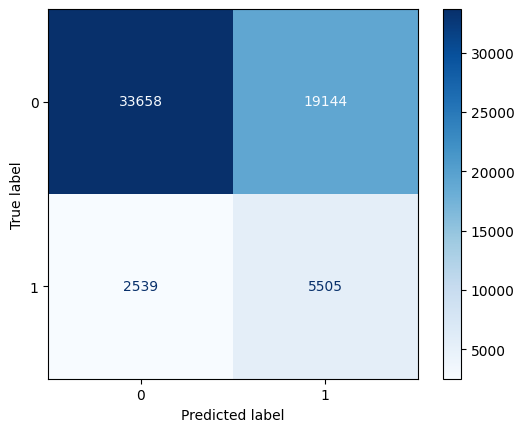

In [ ]:
# Load the last saved model
nb = joblib.load('00_dataset/without_stopwords/nb_classweights/multinomial_nb_batch_X.joblib') # Replace X with the last batch number

# Predict on validation data
y_val_pred = nb.predict(X_val_mmscaled)

# Evaluate performance
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")  # Choose a color map for visualization

In [ ]:
os.makedirs('00_dataset/without_stopwords/lr_classweights', exist_ok=True)

lr = LogisticRegression(max_iter=1000, solver='saga', n_jobs=-1, random_state=42, class_weight='balanced')
lr.fit(X_train_mmscaled, y_train)

joblib.dump(lr, '00_dataset/without_stopwords/lr_classweights/lr_full.joblib')
print("Logistic Regression training completed and saved.")

In [ ]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_mmscaled, y_train)

In [ ]:
nb_smote = MultinomialNB(class_prior=[0.5, 0.5])
nb_smote.fit(X_train_smote, y_train_smote)

# Save the model
joblib.dump(nb_smote, '00_dataset/without_stopwords/nb_classweights/nb_smote.joblib')
print("Naive Bayes with SMOTE training completed and saved.")

In [ ]:
# Train Logistic Regression
lr_smote = LogisticRegression(class_weight='balanced', max_iter=1000, solver='saga')
lr_smote.fit(X_train_smote, y_train_smote)

# Save the model
joblib.dump(lr_smote, '00_dataset/without_stopwords/lr_classweights/lr_smote.joblib')
print("Logistic Regression with SMOTE training completed and saved.")